Today, I want to show you how to take on the classic CIFAR-10 image classification problem and outmaneuver the top-published ResNet-18 models on the Papers with Code Leaderboard. CIFAR-10 is a widely beloved dataset of 32×32 color images across ten classes (cats, dogs, frogs, ships, airplanes, etc.). Because of its modest size, it’s a perfect playground to mix and match advanced tricks—and see how far we can push a standard ResNet-18.

Let's roll up our sleeves and not be afraid to experiment. We'll do a bit of "what if" poking around until we find the best approach. By the end, you’ll see how easy it is to break new ground with the right techniques.

# Create a smaller prototyping dataset from CIFAR10
First, we’ll set up a smaller subset of the training set— about 20%— to make our experiments faster. Whenever I experiment, I want the iterative process to be quick, so I reduce the dataset for prototyping. I shoot for somethign that can train an epoch in less than 30 seconds on my machine.

In [ ]:
from fastai.vision.all import *

path = untar_data(URLs.CIFAR)

def get_20pct_files(path):
    "Return a random 20% subset of image files from the given path."
    files = get_image_files(path)
    # Set the seed for reproducibility
    random.seed(42)
    random.shuffle(files)
    subset_count = int(len(files) * 0.2)
    return files[:subset_count]

path.ls()

Above, we untar the CIFAR-10 dataset and define a helper function that picks 20% of the images. By setting a seed, we keep the subset consistent across runs.

## Inspect the dataset
Here, we’ll look at the images, do some basic transformations (random augmentations, normalization, resizing), and then check that our data is normalized around zero mean and unit standard deviation. This normalizing step is typically crucial to help models train consistently.

In [2]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_20pct_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   batch_tfms=[*aug_transforms(size=24, min_scale=0.75),
                               Normalize.from_stats(*cifar_stats)])

In [3]:
dls = dblock.dataloaders(path/'train', bs=512, seed=42)

We then do a quick mean/std check: if the mean is close to zero and std is close to one, we know our normalization is in good shape.

In [4]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([ 0.0049, -0.0181, -0.0277], device='cuda:0'),
 TensorImage([0.9488, 0.9568, 0.9518], device='cuda:0'))

## Helper Functions for DataLoaders
We’ll define a few variants of get_dls(...) so we can try different transformations quickly—sometimes with normalization, sometimes without, sometimes with more or fewer augmentations.

In [ ]:
#| code-fold: true

def get_dls(bs, size, aug_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_20pct_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(size=aug_size, min_scale=0.75),
                               Normalize.from_stats(*cifar_stats)])
    return dblock.dataloaders(path/'train', bs=bs, seed=42)

def get_dls_no_norm(bs, size, aug_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_20pct_files,
                       get_y=parent_label,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=Resize(size),
                       batch_tfms=aug_transforms(size=aug_size, min_scale=0.75))
    return dblock.dataloaders(path/'train', bs=bs, seed=42)

def get_dls_no_norm_no_aug(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_20pct_files,
                       get_y=parent_label,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=Resize(size))
    return dblock.dataloaders(path/'train', bs=bs, seed=42)

def get_dls_no_aug(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_20pct_files,
                       get_y=parent_label,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=Resize(size),
                       batch_tfms=Normalize.from_stats(*cifar_stats))
    return dblock.dataloaders(path/'train', bs=bs, seed=42)

Looking at a batch of CIFAR-10 data, you see it's 32x32 pixel color images. Many of these are hard for *me* to pick a label for, so a 96% success rate by the model might even outperform my human capability.

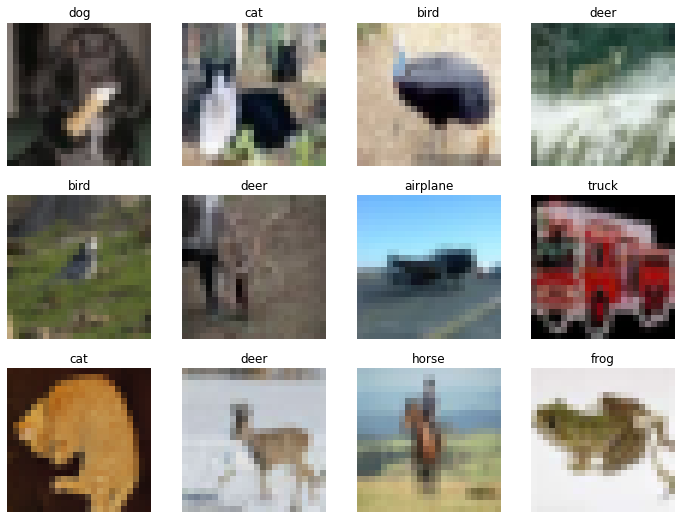

In [ ]:
dls.valid.show_batch(max_n=12, nrows=3, ncols=4)

In [7]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([512, 3, 24, 24]), torch.Size([512]))

# Train a Learner

Now we dive into the heart of the matter: training. We’ll experiment with an off-the-shelf resnet18 from fastai, typically a decent baseline. Then we’ll systematically improve it. We see that by default, the loss is cross-entropy, and the optimizer is Adam. Perfect.

In [ ]:
learn = vision_learner(dls, resnet18, pretrained=False, metrics=accuracy)

In [56]:
learn.loss_func, learn.opt_func

(FlattenedLoss of CrossEntropyLoss(),
 <function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>)

## Baseline Model
47.8% Accuracy

Here’s our baseline training—no fancy bells or whistles, just to see where we stand. I’ll show the code; normally we’d let it run and check the final accuracy. a

In [ ]:
# Baseline Model
n_epochs=32
learn.fit(n_epochs)

The baseline might hover around 47–50% accuracy. That’s a simple reference point—like measuring the “un-augmented" skill of the model. We’ll now run a bunch of experiments, each time reloading the data with different transforms or training hyperparameters, and noting the final accuracy. (I’ve trimmed the epoch-by-epoch logs for brevity.)

## Model Experiments
Leader: Model D2

Accuracy: 93.6%

### Model Z - Original size, resnet18
Accuracy ~ 65.6%. Just by using original 32×32 images with minimal augmentation, we get about two-thirds accuracy.

In [ ]:
# Model Z
dls = get_dls(512, 32, 24)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, base_lr=2e-2, freeze_epochs=3)

### Model Z2 - Original size, smaller bs, resnet18
Accuracy ~ 70.9%. Smaller batch sizes sometimes help or hurt, depending on GPU memory or other hyperparameter interactions. We get a boost here.

In [ ]:
# Model Z2
dls = get_dls(64, 32, 24)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10, base_lr=2e-2, freeze_epochs=3)

### Model A - Size 128, resnet18, small bs
We scale images to 128×128, do a bit more augmentation, and see what happens:

Accuracy ~ 91.3%. A big jump—resizing those tiny CIFAR-10 images to 128×128 and applying more data augmentation helps the model see more varied data.

In [ ]:
## Model A
dls = get_dls(64, 128, 96)
learn = vision_learner(dls, resnet18, metrics=accuracy)
lr = learn.lr_find()

In [ ]:
lr = 3e-3
n_epochs = 32
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

### Model A2 - Size 128, resnet18, small bs, more freeze_epochs
Accuracy ~ 90.9%. Freezing the early layers a bit longer sometimes changes the final outcome. In this run, it’s slightly less than 91.3%.

In [ ]:
# Model A2
dls = get_dls(64, 128, 96)
learn = vision_learner(dls, resnet18, metrics=accuracy)
lr = 3e-3
n_epochs = 32
learn.fine_tune(n_epochs, base_lr=lr, freeze_epochs=3)

### Model B- Size 128, resnet18, small bs, no norm
No normalization to see how important standardizing the data might be. Accuracy ~ 90.2%. Still respectable, but generally standardization is beneficial.


In [ ]:
# Model B
dls = get_dls_no_norm(64, 128, 96)
learn = vision_learner(dls, resnet18, metrics=accuracy)
#learn.lr_find()

In [ ]:
lr = 3e-3
n_epochs = 32
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

### Model C- Size 128, resnet18, small bs, no aug
Accuracy ~ 91.0%. So even with no random augmentations (but still normalized), we break 90%.

In [ ]:
# Model C
dls = get_dls_no_aug(64, 128)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.lr_find()

In [ ]:
lr = 3e-3
n_epochs = 32
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

### Model C3- Size 256, resnet18, small bs
Let’s go bigger still—256×256. With bigger images, the model sees more details: Accuracy: 92.0%

In [ ]:
# Model C3
dls = get_dls(64, 256, 196)
learn = vision_learner(dls, resnet18, metrics=accuracy)
lr = learn.lr_find()

In [ ]:
lr = 3e-3
n_epochs = 32
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

### Model D - Mixup and Label Smoothing
Accuracy ~ 93.5%. This is a hefty leap.

Two powerful techniques:

MixUp: randomly blends two images and their labels, forcing the model not to rely on too-literal image cues.
Label Smoothing: slightly softens the one-hot labels, mitigating overconfidence.

In [ ]:
# Model D - Mixup and Label Smoothing
dls = get_dls(64, 256, 196)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.lr_find()

In [ ]:
lr=3e-3
n_epochs=32
learn = vision_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy, cbs=MixUp())
learn.fine_tune(n_epochs, base_lr=lr)

### Model E0 - Progressive Resizing

Accuracy: 90.0%

We train first on smaller images, then gradually increase their size. This can help if you’re using a pretrained model so it first learns broad features, then refines them with bigger images. But on CIFAR-10, which is already small, it’s not always beneficial.


In [ ]:
# Model E0 - Progressive Resizing
n_epochs = 16
lr = 3e-3

dls = get_dls(64, 128, 96)
learn = vision_learner(dls, resnet18, pretrained=False, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy, cbs=MixUp())
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

learn.dls = get_dls(64, 256, 196)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(n_epochs, base_lr=lr)

### Model F- Discriminative Learning Rates
Accuracy: 90.8%

The idea: later layers can use higher learning rates while earlier, more general layers use a lower one. In fastai, we do this with a range (slice(lr/10, lr*10)).

In [13]:
# Model F
lr=3e-3
n_epochs=32
dls = get_dls(64, 256, 196)
learn = vision_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(1, lr_max=lr)
learn.lr_find()

In [ ]:
lr=2e-3
learn.fit_one_cycle(n_epochs, lr_max=slice(lr/10,lr*10))

### Model D2- Mixup and Label Smoothing, Mixed Point Precision
Accuracy: 93.6%

We add one more trick: Mixed-precision training (a.k.a. fp16). It runs your forward/backward passes in half precision on the GPU, speeding things up and sometimes improving generalization.

In [ ]:
# Model D Mixed Point
dls = get_dls(64, 256, 196)
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.lr_find()
lr=3e-3
n_epochs=32
learn = vision_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy, cbs=MixUp()).to_fp16()
learn.fine_tune(n_epochs, base_lr=lr)

# Train the winning model on the full dataset
All this time, we only tested on a 20% subset for speed. Once we identify that MixUp + Label Smoothing + fp16 (Model D2) is the best formula, we unleash it on the entire CIFAR-10 dataset. Let’s watch it climb higher:

In [ ]:
# Train the winning model on the full dataset

def get_dls(bs, size, aug_size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(size=aug_size, min_scale=0.75),
                               Normalize.from_stats(*cifar_stats)])
    return dblock.dataloaders(path/'train', bs=bs, seed=42)

# Model D - Mixup and Label Smoothing
dls = get_dls(64, 256, 196)
lr=3e-3
n_epochs=100
learn = vision_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy, cbs=MixUp()).to_fp16()
learn.fine_tune(n_epochs, base_lr=lr)

![](train-log-1.png)
![](train-log-2.png)
![](train-log-3.png)



If you let it run all the way, you see an accuracy around 95.56%, which (as of this writing) beats the #1 ResNet-18 model on the Papers With Code leaderboard for CIFAR-10. That’s a big statement about how powerful these modern training tricks can be—even on a famously “solved” dataset like CIFAR-10. With test time augmentation, accuracy climbs even high, to 96.02%

In [4]:
# Apply Test Time Augmentation 
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.9602000117301941

# Conclusion
The moral of this story is: be playful, combine known ideas (data augmentation, MixUp, Label Smoothing, bigger images, discriminative learning rates, and half-precision), and see if you can outdo the established baselines. Sometimes, you can surpass them just by mixing these techniques carefully!

Happy experimenting—and remember, science is all about tweaking, testing, and delighting in the surprises you find along the way.